# Домашнее задание
* Прочитать про методы оптимизации для нейронных сетей https://habr.com/post/318970/
* Реализовать самостоятельно логистическую регрессию
    * Обучить ее методом градиентного спуска
    * Методом nesterov momentum
    * Методом rmsprop
* В качестве dataset'а взять Iris, оставив 2 класса:
    * Iris Versicolor
    * Iris Virginica

In [ ]:
from sklearn import datasets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix

In [ ]:
# Скачиваем датасет
iris = datasets.load_iris()

In [ ]:
# Читаем предикторы (X) и зависимую переменную (y)
X = pd.DataFrame(data= iris.data, columns= iris.feature_names)
y = pd.Series(data= iris.target, name= 'target' )

In [ ]:
# Посмотрим названия классов
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
# Заменим коды класса на его название
y = y.map({0: 'setosa', 1: 'versicolor', 2: 'virginica'},)

In [ ]:
y

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: target, Length: 150, dtype: object

In [ ]:
# Выполняем условие задания: исключаем setosa, и перекодируем обратно, чтобы было 0 и 1 для логистической регрессии
y=y[y!='setosa']
X = X[X.index.isin(y.index)]
y = y.map({'versicolor': 0, 'virginica': 1},)

### Определение функций

In [ ]:
# Функция, рисующая матрицу ошибок
# cm - объект confusion_matrix, classes - список названий классов
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    import itertools
    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Oranges)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# добавление единичного столбца для вычисления в линейной регрессии числа 'a' из y = k*x + a
def add_intercept(X):
  intercept = np.ones((X.shape[0], 1))
  return np.concatenate((intercept, X), axis=1)

In [ ]:
# Сглаживающая функция для классификации - Сигмоид, можно поставить свою функцию
def sigmoid(z):
  return 1. / (1 + np.exp(-z))

In [ ]:
# Функция потерь - можно определять свою функцию
def loss_function(z):
  loss = -np.mean(np.log(z) * y + np.log(1 - z) * (1 - y))
  return loss

In [ ]:
# Классифицирующая функция, пропущенная через сигмоиду
def predict_prob(theta, X):
  if len(theta) == X.shape[1] + 1:
    X = add_intercept(X)
    
  predict_prob = X.dot(theta)
  return sigmoid(predict_prob)

In [ ]:
# Выдает предсказанный класс
def predict(theta, X):
  return predict_prob(theta, X).round()

Главная функция - обучение логистической регрессии. Принимает:
- X,y для обучения;
- theta - начальное приближение; 
- method - каким методом обучать (градиентный спуск, Нестеров моментум или RMSProp. 

И так же параметры самих методов 
- количество эпох обучения num_iter, 
- скорость обучения lr
- параметры методов gamma и eps

Выдает:
- рассчетные значения theta - чтобы затем обращаться к функции predict
- историю снижения значения ошибки

In [ ]:
# Главная функция - обучение логистической регрессии
def LogisticRegression_fit(X, y, theta,
                           method='gradient',
                           num_iter=100, 
                           lr=0.05, 
                           gamma=0.975,
                           eps=0.00000001,
                           fit_intercept=True):

  if fit_intercept:
    X = add_intercept(X)
  
  if method == 'NM':
    theta,fit_history = NM(X, y, theta, num_iter, lr, gamma)
  elif method == 'RMSProp':
    theta,fit_history = RMSProp(X, y, theta, num_iter, lr, gamma, eps)
  else:
    theta,fit_history = gradient(X, y, theta, num_iter, lr)

  return theta,fit_history

## Простой градиент

In [ ]:
# Простой градиент
def gradient(X, y, theta, num_iter=50, lr=0.05):

  gradient_history = []
  
  for _ in range(num_iter):
    sigm = predict_prob(theta, X)
    theta -= lr * np.dot(X.T, (sigm - y)) / y.size

    loss = loss_function(sigm)
    gradient_history.append(loss)
  
  return theta, gradient_history

Попробуем обучить нашу регрессию методом градиентного спуска. Для этого зададим начальное распределение theta и вызовем обучающую функцию с параметрами по умолчанию:

In [ ]:
# начальное приближение
theta0 = [-0.6, -1.4, 0.2, -1.4,  2.2]

In [ ]:
# обучим методом градиентного спуска
theta, grad_loss_hist = LogisticRegression_fit(X,y,theta0,'gradient')

In [ ]:
theta

array([-0.59595358, -0.66631124,  0.31721679, -0.12109318,  2.75477084])

Рассчитаем матрицу ошибок и выведем графическое представление

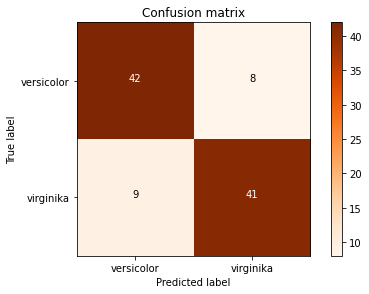

In [ ]:
cm = confusion_matrix(y,predict(theta, X))
plot_confusion_matrix(cm,['versicolor','virginika'])

Семнадцать ошибок. Посмотрим, что дадут другие методы

## nesterov momentum

In [ ]:
# nesterov momentum
def NM(X, y, theta, num_iter=50, lr=0.05, gamma=0.2):
  v = np.zeros(5)
  nm_histoty = []
  sigm = predict_prob(theta, X)
  v = gamma * v + lr * np.dot(X.T, (sigm - y)) / y.size

  for _ in range(num_iter):

    sigm = predict_prob(theta, X)

    v = gamma * v + lr * np.dot(X.T, (sigm - y)) / y.size

    theta -= v
    loss = loss_function(sigm)

    nm_histoty.append(loss)

  return theta, nm_histoty

Повторим те же манипуляции для метода Нестеров Моментум:

In [ ]:
# обучим методом НМ
theta, nest_loss_hist = LogisticRegression_fit(X,y,theta0,'NM',gamma=0.2)

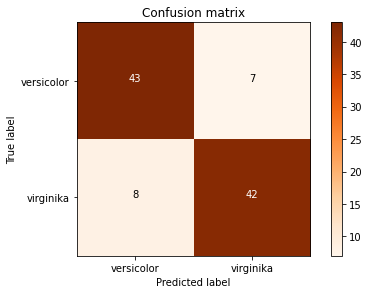

In [ ]:
cm = confusion_matrix(y,predict(theta, X))
plot_confusion_matrix(cm,['versicolor','virginika'])

## RMSProp

In [ ]:
# RMSProp
def RMSProp(X, y, theta, num_iter=50, lr=0.05, gamma=0.975, eps = 0.00000001):
  EG = np.zeros(5)
  rmsp_history = []
  
  for _ in range(num_iter):
    sigm = predict_prob(theta, X)
    grad = np.dot(X.T, (sigm - y)) / y.size

    EG = gamma * EG + (1 - gamma)  * grad ** 2
    
    theta -= lr * grad / np.sqrt(EG + eps)
    loss = loss_function(sigm)
    rmsp_history.append(loss)
  
  return theta, rmsp_history

И наконец третий метод - RMSProp

In [ ]:
# обучим методом RMSProp
theta, rmsp_loss_hist = LogisticRegression_fit(X,y,theta0,'RMSProp')

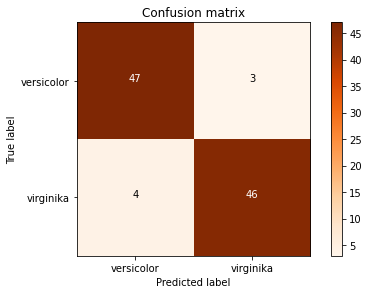

In [ ]:
cm = confusion_matrix(y,predict(theta, X))
plot_confusion_matrix(cm,['versicolor','virginika'])

Совсем мало ошибок, сравним скорость убывания потерь на графике:

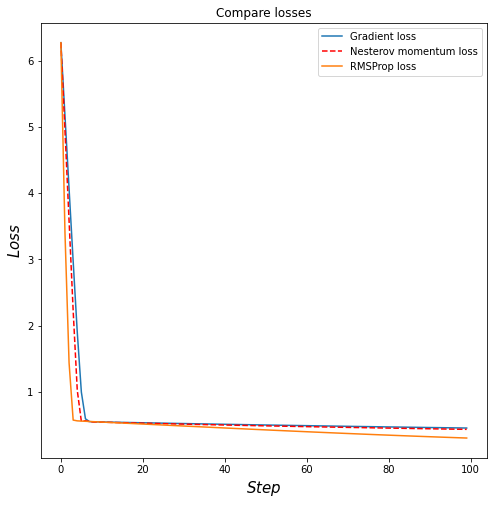

In [ ]:
# Сравним скорость убывания ошибки
plt.figure(figsize=(8,8))
plt.plot(grad_loss_hist, label='Gradient loss' )
plt.plot(nest_loss_hist, 'r--', label='Nesterov momentum loss')
plt.plot(rmsp_loss_hist, label='RMSProp loss' )
plt.title('Compare losses')
plt.xlabel('$Step$', fontsize=15)
plt.ylabel('$Loss$', fontsize=15)
plt.legend()
plt.show()

Можно сделать вывод, что по скорости убывания потерь и по результирующему соотношению ошибок по классам, лучше всего - при таких настройках - ведет себя метод RMSProp.

# Эксперименты

In [ ]:
theta0 = [-0.6, -1.4, 0.2, -1.4,  2.2]
#theta0 = [-0.41, -0.19, -0.03, 0.38,  0.68]
#theta0 = [-0.6655, -1.4678, -0.2125, -0.1487,  2.2279]
theta, grad_loss_hist = LogisticRegression_fit(X,y,theta0,'gradient')
theta, nest_loss_hist = LogisticRegression_fit(X,y,theta0,'NM',gamma=0.2)
theta, rmsp_loss_hist = LogisticRegression_fit(X,y,theta0,'RMSProp')

Методы очень по-разному себя ведут в зависимости от выбранной точки начала, а также от параметров, проведем некоторые исследования:

Метод Нестеров моментум с разным значением gamma. Можно увидеть как меняется поведение.

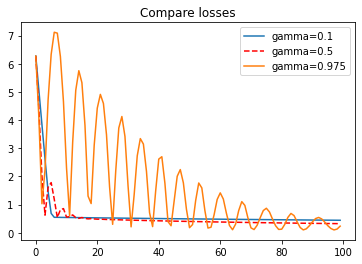

In [ ]:
theta0 = [-0.6, -1.4, 0.2, -1.4,  2.2]
theta, loss_hist1 = LogisticRegression_fit(X,y,theta0,'NM',gamma=0.1)
theta, loss_hist2 = LogisticRegression_fit(X,y,theta0,'NM',gamma=0.7)
theta, loss_hist3 = LogisticRegression_fit(X,y,theta0,'NM',gamma=0.975)

plt.plot(loss_hist1, label='gamma=0.1' )
plt.plot(loss_hist2, 'r--', label='gamma=0.7')
plt.plot(loss_hist3, label='gamma=0.975' )
plt.title('Compare losses')
plt.legend()

Такое же исследование - для метода RMSProp.

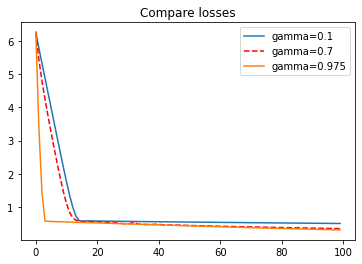

In [ ]:
theta0 = [-0.6, -1.4, 0.2, -1.4,  2.2]
theta, loss_hist1 = LogisticRegression_fit(X,y,theta0,'RMSProp',gamma=0.1)
theta, loss_hist2 = LogisticRegression_fit(X,y,theta0,'RMSProp',gamma=0.7)
theta, loss_hist3 = LogisticRegression_fit(X,y,theta0,'RMSProp',gamma=0.975)

plt.plot(loss_hist1, label='gamma=0.1' )
plt.plot(loss_hist2, 'r--', label='gamma=0.7')
plt.plot(loss_hist3, label='gamma=0.975' )
plt.title('Compare losses')
plt.legend()

Покажем пример неудачной выбранной точки - заметим, что ошибка алгоритма RMSProp по матрице ошибок - 36 раз.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


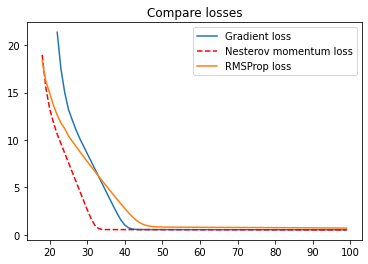

In [ ]:
theta0 = [11.6, 1.4, -0.2, 11.4,  -2.2]
theta, grad_loss_hist = LogisticRegression_fit(X,y,theta0,'gradient')
theta, nest_loss_hist = LogisticRegression_fit(X,y,theta0,'NM',gamma=0.2)
theta, rmsp_loss_hist = LogisticRegression_fit(X,y,theta0,'RMSProp')

plt.plot(grad_loss_hist, label='Gradient loss' )
plt.plot(nest_loss_hist, 'r--', label='Nesterov momentum loss')
plt.plot(rmsp_loss_hist, label='RMSProp loss' )
plt.title('Compare losses')
plt.legend()

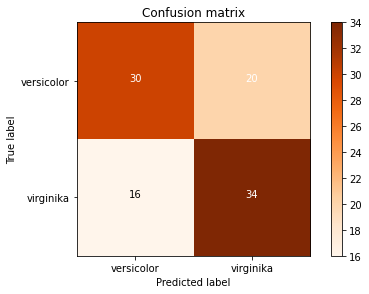

In [ ]:
cm = confusion_matrix(y,predict(theta, X))
plot_confusion_matrix(cm,['versicolor','virginika'])

Однако - для той же, неудачной точки, если алгоритмам дать достаточно эпох для обучения и задать медленную скорость обучения, алгоритмы придут к хорошему результату.

На примере (количество итераций num_iter = 3000, скорость обучения lr = 0.005) видно, что все методы быстренько сошлись примерно на 1250-й итерации, хотя и тут - после 3000 итераций лучше себя показывает метод RMSProp, хотя поначалу его скорость схождения уступала двум другим методам.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


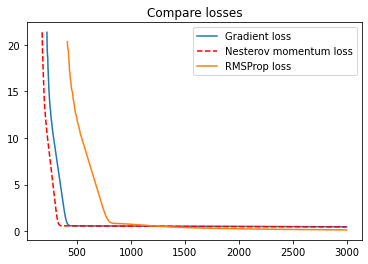

In [ ]:
theta0 = [11.6, 1.4, -0.2, 11.4,  -2.2]
theta, grad_loss_hist = LogisticRegression_fit(X,y,theta0,'gradient',num_iter=3000, lr=0.005)
theta, nest_loss_hist = LogisticRegression_fit(X,y,theta0,'NM',num_iter=3000, lr=0.005,gamma=0.2)
theta, rmsp_loss_hist = LogisticRegression_fit(X,y,theta0,'RMSProp',num_iter=3000, lr=0.005)

plt.plot(grad_loss_hist, label='Gradient loss' )
plt.plot(nest_loss_hist, 'r--', label='Nesterov momentum loss')
plt.plot(rmsp_loss_hist, label='RMSProp loss' )
plt.title('Compare losses')
plt.legend()

Посмотрим, что покажет нам матрица ошибок для метода RSMProp после 3000 итераций:

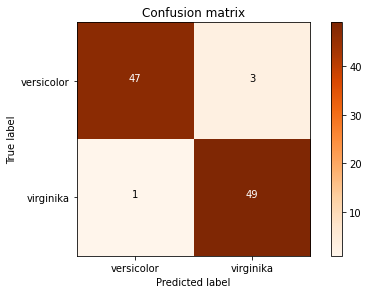

In [ ]:
cm = confusion_matrix(y,predict(theta, X))
plot_confusion_matrix(cm,['versicolor','virginika'])

Всего 4 ошибки! Эксперименты показывают, что можно и лучше, но на этом, пожалуй, можно остановиться.